### Load and Use DeepForest for Object Detection

The DeepForest model is primarily used for detecting trees in aerial or satellite imagery. Here’s how you can use it:

Reading config file: /data2/lukas/projects/throwing_shade/.samgeo_env/lib/python3.10/site-packages/deepforest/data/deepforest_config.yml


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


/data2/lukas/projects/throwing_shade/.samgeo_env/lib/python3.10/site-packages/deepforest/main.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dic

Predicting: |          | 0/? [00:00<?, ?it/s]

3817 predictions in overlapping windows, applying non-max supression
2207 predictions kept after non-max suppression


/data2/lukas/projects/throwing_shade/.samgeo_env/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = t

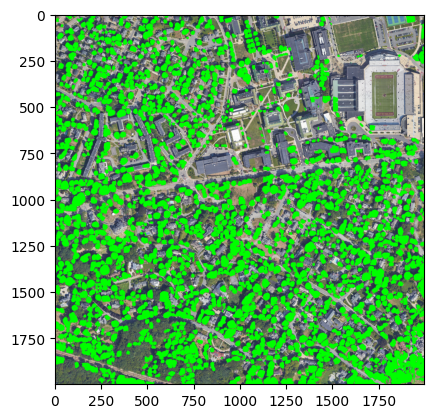

In [5]:
from deepforest import main
import cv2
import numpy as np
import rasterio
from rasterio.transform import from_origin
from segment_anything import SamPredictor, sam_model_registry
import torch
import matplotlib.pyplot as plt

# Load the DeepForest model
model = main.deepforest()
model.use_release()

# Load the image and predict bounding boxes using DeepForest
# raster_path = "../data/clean_data/solar/12011952/12011952_p_1_2022_06_02_rgb.tif"
raster_path = "../data/clean_data/solar/2315704/2315704_p_56_2022_07_01_rgb.tif"

image = cv2.imread(raster_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predicted_mask = model.predict_tile(raster_path, return_plot=False, patch_size=300, patch_overlap=0.25)

# Load the SAM model
sam_checkpoint = "../data/clean_data/sam/sam_vit_h_4b8939.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

# Set the image for segmentation
predictor.set_image(image)

# Create an empty mask with the same dimensions as the original image
final_mask = np.zeros(image.shape[:2], dtype=np.uint8)

# Iterate through the detected objects and use SAM to segment them
for i, prediction in predicted_mask.iterrows():
    x1, y1, x2, y2 = int(prediction['xmin']), int(prediction['ymin']), int(prediction['xmax']), int(prediction['ymax'])

    # Create a box prompt for SAM
    box = np.array([x1, y1, x2, y2])

    # Predict the mask using SAM
    masks, _, _ = predictor.predict(box=box)

    # Combine the SAM mask into the final mask
    for mask in masks:
        final_mask[mask] = 255  # Assuming binary segmentation, 255 for foreground

# Visualize the final overlay
overlay_image = image.copy()
overlay_image[final_mask > 0] = [0, 255, 0]  # Color the masked area

plt.imshow(overlay_image)
plt.show()

# # Save the final mask as a georeferenced TIFF
# with rasterio.open(raster_path) as src:
#     transform = src.transform
#     crs = src.crs

# # Save the mask as a GeoTIFF
# output_path = "segmented_output.tif"
# with rasterio.open(
#         output_path,
#         'w',
#         driver='GTiff',
#         height=final_mask.shape[0],
#         width=final_mask.shape[1],
#         count=1,
#         dtype=final_mask.dtype,
#         crs=crs,
#         transform=transform,
# ) as dst:
#     dst.write(final_mask, 1)

# print(f"Segmented mask saved to {output_path}")

In [ ]:


from deepforest import main
import cv2
import numpy as np
import rasterio
from rasterio.transform import from_origin
from segment_anything import SamPredictor, sam_model_registry
import torch
import matplotlib.pyplot as plt



def main(date):
    # Initialize the parser
    parser = argparse.ArgumentParser(description="Process a OSM area.")
    
    # Add the argument
    parser.add_argument('number', type=int, help='OSMID to be processed')

    # Parse the arguments
    args = parser.parse_args()

    # Access the number argument
    osmid = args.number

    print(f'working on OSMID:{osmid}')

    # print(dt.datetime.now())

    # Directory containing the raster files
    raster_dir = f'../data/clean_data/solar/{osmid}'

    # Get a list of all raster files in the directory so we can load them incrementally
    raster_files = glob.glob(os.path.join(raster_dir, '*dsm.tif'))

    print(f'Found {len(raster_files)} tiles')


### make this into a function where it processes all raster_files and saves the masks to a new folder
# Load the DeepForest model
model = main.deepforest()
model.use_release()

# Load the image and predict bounding boxes using DeepForest
# raster_path = "../data/clean_data/solar/12011952/12011952_p_1_2022_06_02_rgb.tif"
raster_path = "../data/clean_data/solar/2315704/2315704_p_56_2022_07_01_rgb.tif"

image = cv2.imread(raster_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predicted_mask = model.predict_tile(raster_path, return_plot=False, patch_size=300, patch_overlap=0.25)

# Load the SAM model
sam_checkpoint = "../data/clean_data/sam/sam_vit_h_4b8939.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

# Set the image for segmentation
predictor.set_image(image)

# Create an empty mask with the same dimensions as the original image
final_mask = np.zeros(image.shape[:2], dtype=np.uint8)

# Iterate through the detected objects and use SAM to segment them
for i, prediction in predicted_mask.iterrows():
    x1, y1, x2, y2 = int(prediction['xmin']), int(prediction['ymin']), int(prediction['xmax']), int(prediction['ymax'])

    # Create a box prompt for SAM
    box = np.array([x1, y1, x2, y2])

    # Predict the mask using SAM
    masks, _, _ = predictor.predict(box=box)

    # Combine the SAM mask into the final mask
    for mask in masks:
        final_mask[mask] = 255  # Assuming binary segmentation, 255 for foreground

# Visualize the final overlay
overlay_image = image.copy()
overlay_image[final_mask > 0] = [0, 255, 0]  # Color the masked area

plt.imshow(overlay_image)
plt.show()

# # Save the final mask as a georeferenced TIFF
# with rasterio.open(raster_path) as src:
#     transform = src.transform
#     crs = src.crs

# # Save the mask as a GeoTIFF
# output_path = "segmented_output.tif"
# with rasterio.open(
#         output_path,
#         'w',
#         driver='GTiff',
#         height=final_mask.shape[0],
#         width=final_mask.shape[1],
#         count=1,
#         dtype=final_mask.dtype,
#         crs=crs,
#         transform=transform,
# ) as dst:
#     dst.write(final_mask, 1)

# print(f"Segmented mask saved to {output_path}")


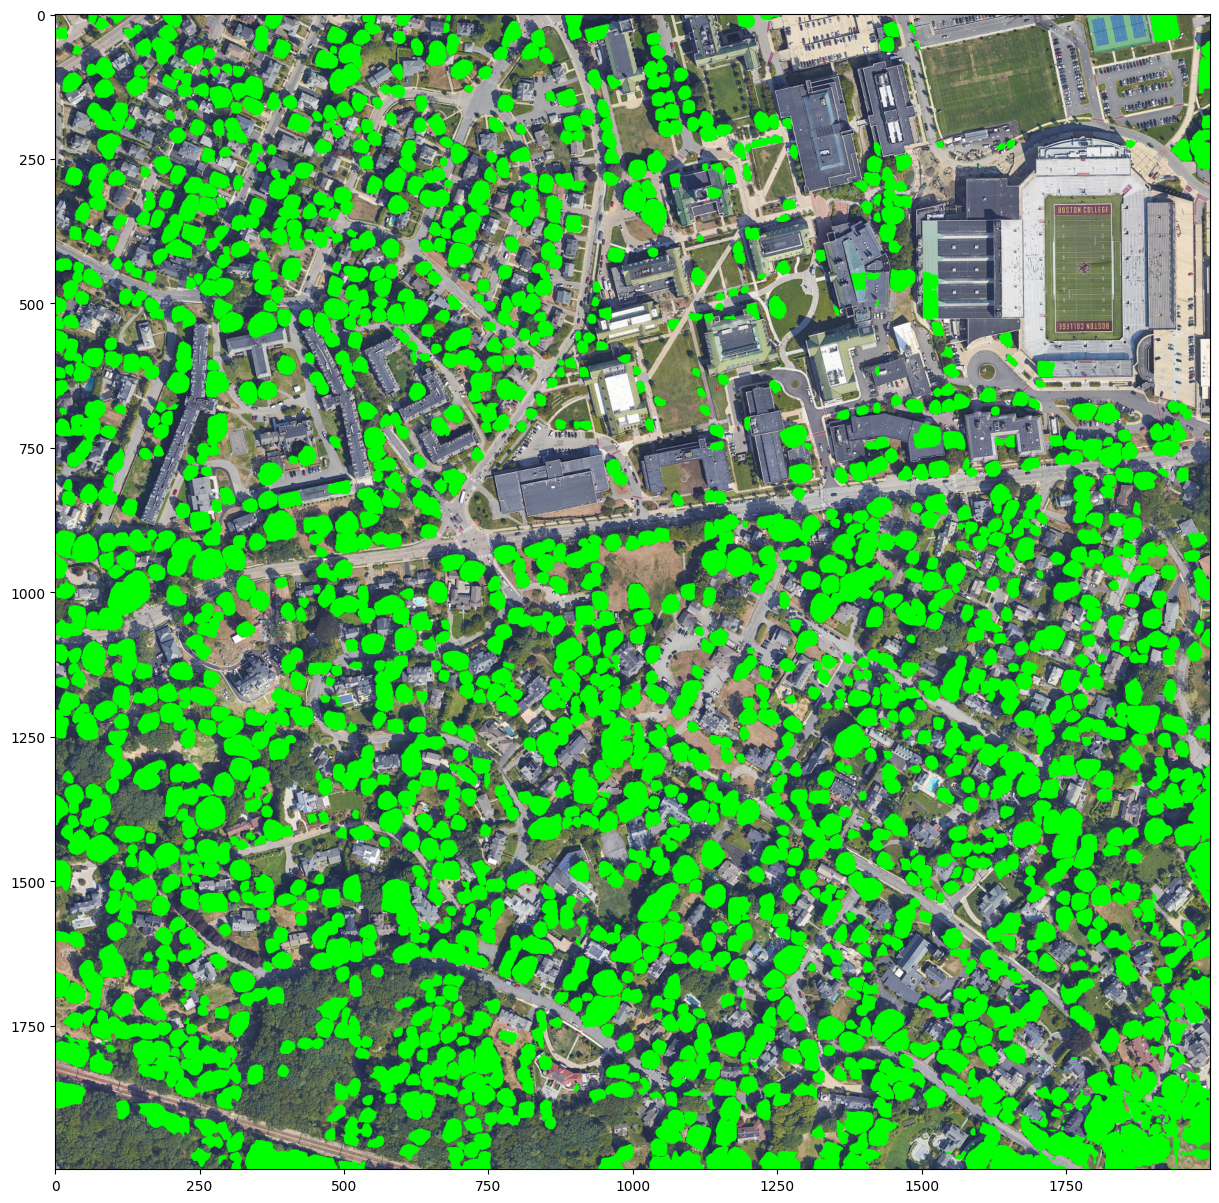

In [6]:
plt.figure(figsize=(15,15))
plt.imshow(overlay_image)
plt.show()

In [3]:
# Save the final mask as a georeferenced TIFF
with rasterio.open(raster_path) as src:
    transform = src.transform
    crs = src.crs

# Save the mask as a GeoTIFF
output_path = "../results/output/sam/segmented_output.tif"
with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=final_mask.shape[0],
        width=final_mask.shape[1],
        count=1,
        dtype=final_mask.dtype,
        crs=crs,
        transform=transform,
) as dst:
    dst.write(final_mask, 1)

print(f"Segmented mask saved to {output_path}")

Segmented mask saved to ../results/output/sam/segmented_output.tif


### Post-Processing and Visualization

You can post-process the masks to refine them or combine them with the original image. For example, overlaying the masks on the original image or bounding boxes to see the segmentation results.

In [43]:
# Overlay mask on the original image
overlay_image = image.copy()
for mask in masks:
    overlay_image[mask] = [0, 255, 0]  # Color the masked area

cv2.imshow("Overlay", overlay_image)
cv2.waitKey(0)

3

### Saving the Results

You can save the segmented images or masks for further use:

In [ ]:
cv2.imwrite("segmented_image.png", overlay_image)